In [1]:
# Charger le fichier CSV (modifiez 'path_to_file.csv' avec votre propre chemin de fichier)
file_path = 'dataMunich/ACCData/device3-2024-09-14T18_29_05.csv'
folder_path = 'dataNous/'

### Imports

In [2]:
import os
import json
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [3]:
from pipeline_classifier import *

# Metriques

Rapport de classification sur les données de test :
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        22
         1.0       0.80      1.00      0.89         4

    accuracy                           0.96        26
   macro avg       0.90      0.98      0.93        26
weighted avg       0.97      0.96      0.96        26

Le modèle a été sauvegardé sous : c:\Users\User\OneDrive\Bureau\SCIA-G\pfee-munic\classifier\random_forest_model.joblib

Random Forest:

--- Évaluation du modèle : Random Forest ---
ROC AUC: 0.99
Précision: 1.00
Rappel: 0.79
F1-score: 0.89


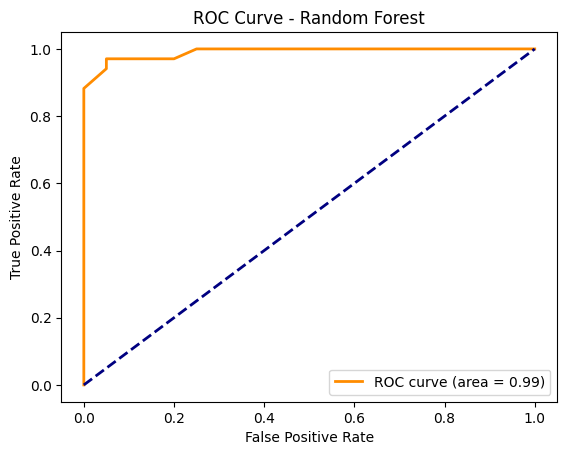

Le fichier dataMunich/ACCData/device3-2024-09-14T18_29_05.csv contient des données montrant : 
Prédiction: Crash détecté


In [4]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Fonction pour calculer les métriques et tracer la courbe ROC
def evaluate_model(y_test, y_prob, y_pred, model_name):
    print(f"--- Évaluation du modèle : {model_name} ---")
    
    # Calcul des métriques
    roc_auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Affichage des métriques
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Précision: {precision:.2f}")
    print(f"Rappel: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    
    # Tracer la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Entraînement et évaluation du modèle Random Forest
folder_path = './dataNous'
clf_rf, scaler_rf = load_and_train(folder_path, pourcent_accident=0.2, save_model=True, model_name="random_forest_model.joblib")

# Charger les données pour tester le modèle
X, y = load_data(folder_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test_scaled = scaler_rf.transform(X_test)

# Prédire avec le modèle Random Forest
y_prob_rf = clf_rf.predict_proba(X_test_scaled)[:, 1]
y_pred_rf = predic_with_threshold(y_prob_rf, threshold=0.7)
print("\nRandom Forest:\n")

# Évaluation du modèle Random Forest
evaluate_model(y_test, y_prob_rf, y_pred_rf, model_name="Random Forest")

# Tester un fichier de test avec le modèle Random Forest
test_file(file_path, scaler_rf, clf_rf, threshold=0.7)





Isolation Forest:

Le modèle a été sauvegardé sous : c:\Users\User\OneDrive\Bureau\SCIA-G\pfee-munic\classifier\isolation_forest_model.joblib
Rapport de classification sur les données de test :
              precision    recall  f1-score   support

           0       0.47      1.00      0.63        20
           1       1.00      0.32      0.49        34

    accuracy                           0.57        54
   macro avg       0.73      0.66      0.56        54
weighted avg       0.80      0.57      0.54        54

AUC ROC: 0.92


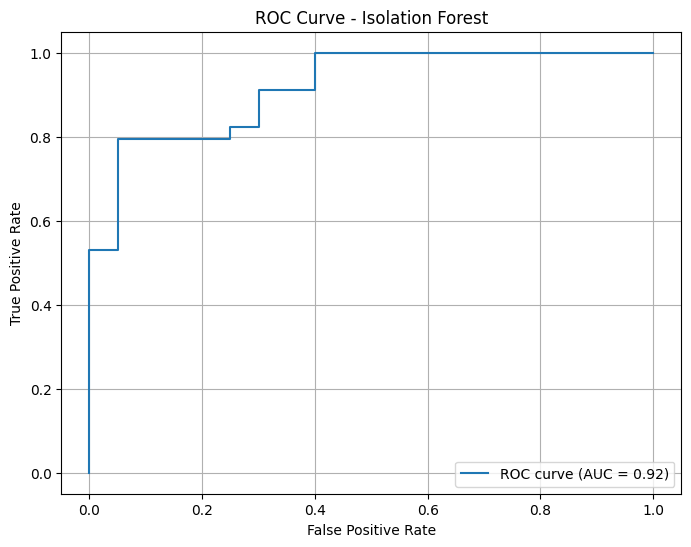

Metrics:
Precision: 1.00
Recall: 0.32
F1-Score: 0.49


In [5]:
print("\nIsolation Forest:\n")
# Entraînement et évaluation du modèle Isolation Forest
clf_if, scaler_if = train_outlier_model(folder_path, pourcent_accident=0.2, save_model=True, model_name="isolation_forest_model.joblib")

# Obtenir les scores d'anomalie
anomaly_scores = clf_if.decision_function(X_test)

# Convertir les scores en prédictions (1 pour outlier, 0 pour inlier)
threshold = np.percentile(anomaly_scores, 100 * 0.2)  # Définir le seuil basé sur le pourcentage d'anomalies attendu
y_pred = (anomaly_scores < threshold).astype(int)

# Rapport de classification
print("Rapport de classification sur les données de test :")
print(classification_report(y_test, y_pred))

# Calculer et afficher l'AUC ROC
roc_auc = roc_auc_score(y_test, -anomaly_scores)  # Inverser les scores pour que les outliers soient positifs
print(f"AUC ROC: {roc_auc:.2f}")

# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, -anomaly_scores)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Isolation Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    """
    Calculate precision, recall, and F1-score.
    
    Parameters:
    - y_true: array-like, true labels (0 = inlier, 1 = outlier).
    - y_pred: array-like, predicted labels (0 = inlier, 1 = outlier).
    
    Returns:
    - metrics: dict with precision, recall, and F1-score.
    """
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    
    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    return metrics

metrics = calculate_metrics(y_test, y_pred)
print("Metrics:")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1-Score: {metrics['f1_score']:.2f}")